<a href="https://colab.research.google.com/github/aritraghsh09/GaMPEN/blob/master/tutorials/Autocropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocropping with GaMPEN


In this Jupyter Notebook, we will demonstrate how you can use the Spatial Transform Network component of a trained GaMPEN model to automatically crop input images and save them -- for any kind of further analysis.

## Preliminary stuff

### Connect to GPU runtime

Before we dive in, note that Google Colab gives you the ability to use GPUs for this tutorial.  

To do this, on the Google Colab menu bar select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

### Installing GaMPEN

First, let's install GaMPEN. 

Some of these commands are specifically for Google Colab. If doing this on your own machine, please follow the steps outlined [here](https://gampen.readthedocs.io/en/latest/Getting_Started.html)

In [ ]:
!git clone https://github.com/aritraghsh09/GaMPEN.git

Cloning into 'GaMPEN'...
remote: Enumerating objects: 2310, done.
remote: Counting objects: 100% (658/658), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 2310 (delta 416), reused 564 (delta 340), pack-reused 1652
Receiving objects: 100% (2310/2310), 24.55 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (1504/1504), done.


In [ ]:
%cd /content/GaMPEN/

!pip install -r requirements.txt 

/content/GaMPEN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/GaMPEN (from -r requirements.txt (line 2))
  Cloning https://github.com/adambielski/GrouPy (to revision e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7) to /tmp/pip-install-v9niuy60/groupy_718f62fcbdc74eec8942ab870164584e
  Running command git clone -q https://github.com/adambielski/GrouPy /tmp/pip-install-v9niuy60/groupy_718f62fcbdc74eec8942ab870164584e
  Running command git rev-parse -q --verify 'sha^e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7'
  Running command git fetch -q https://github.com/adambielski/GrouPy e9c2e5ae8f2234359a9f68b52d9d430d9a72f4d7
     |████████████████████████████████| 1.1 MB 35.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.5 MB 63.4 MB/s 
     |████████████████████████████████| 121 kB 71.2 MB/s 
     |██

### Checking the Installation

In order to check whether the installation has occured succesfully, run the command below.  

In [ ]:
!make check

flake8 --ignore=E203,W503 ggt
pytest
============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-6.0.1, py-1.9.0, pluggy-0.13.1
rootdir: /content/GaMPEN
plugins: typeguard-2.7.1
collected 7 items                                                              

ggt/tests/test_install.py .                                              [ 14%]
ggt/tests/test_metrics.py .                                              [ 28%]
ggt/tests/test_models.py ...s                                            [ 85%]
ggt/tests/test_utils.py .                                                [100%]

======================== 6 passed, 1 skipped in 11.62s =========================


As long as the tests do not produce any errors, you are good to go! 

Note that warnings and and tests being skipped are ok! 

## Getting Images & Models to Perform Prediction

### Downloading Images and Creating the Necessary Folder Structure

Let's get some Hyper Suprime Cam images from its 2nd Public Data Release that we can crop. For this demo, we will use the images from Fig. 13 of [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf)


In [ ]:
# Let's create two data-directories in our Colab runtime
# One containing low-z images and one containing mid-z images. 
%cd /content/
!mkdir data_lowz
!mkdir data_lowz/cutouts/
!mkdir data_midz
!mkdir data_midz/cutouts/

/content


In [ ]:
#Now let's download the images from Yale FTP Servers

%cd /content/data_lowz/cutouts/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/cutouts/*.fits

%cd /content/data_midz/cutouts/
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_midz/cutouts/*.fits

/content/data_lowz/cutouts
--2022-12-17 23:42:08--  ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/cutouts/*.fits
           => ‘.listing’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/cutouts ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]     279  --.-KB/s    in 0.003s  

2022-12-17 23:42:11 (109 KB/s) - ‘.listing’ saved [279]

Removed ‘.listing’.
--2022-12-17 23:42:11--  ftp://ftp.astro.yale.edu/pub/hsc_morph/gampen_tutorial_files/for_preds/data_lowz/cutouts/45849776612206843.fits
           => ‘45849776612206843.fits’
==> CWD not required.
==> PASV ... done.    ==> RETR 45849776612206843.fits ... done.
Length: 288000 (281K)

4

### Downloading the Trained Models

Now, let's download the models we trained on Hyper Suprime Cam Imaging in [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf). Since our images are from the low and mid redshift bins, we download the corresponding trained models. 

In [ ]:
%cd /content/
%mkdir trained_models
%cd trained_models

!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/trained_model/g_0_025_real_data.pt
!wget ftp://ftp.astro.yale.edu/pub/hsc_morph/r_025_050/trained_model/r_025_050_real_data.pt

/content
/content/trained_models
--2022-12-17 23:42:21--  ftp://ftp.astro.yale.edu/pub/hsc_morph/g_0_025/trained_model/g_0_025_real_data.pt
           => ‘g_0_025_real_data.pt’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/hsc_morph/g_0_025/trained_model ... done.
==> SIZE g_0_025_real_data.pt ... 572517399
==> PASV ... done.    ==> RETR g_0_025_real_data.pt ... done.
Length: 572517399 (546M) (unauthoritative)

g_0_025_real_data.p 100%[===================>] 546.00M  11.7MB/s    in 47s     

2022-12-17 23:43:11 (11.6 MB/s) - ‘g_0_025_real_data.pt’ saved [572517399]

--2022-12-17 23:43:12--  ftp://ftp.astro.yale.edu/pub/hsc_morph/r_025_050/trained_model/r_025_050_real_data.pt
           => ‘r_025_050_real_data.pt’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 

**⚠ NOTE:** Details about all the publicly-available GaMPEN models as well as the morphological catalogs for all galaxies in [Ghosh et. al. 2022](https://arxiv.org/pdf/2212.00051.pdf) can be found in our [Public Data Release Handbook](https://gampen.readthedocs.io/en/latest/Public_data.html)

### Inspecting the Files

Now, let's take a quick look at the images. Note that HSC's cutout tool sometimes returns images with slightly different cutout-sizes (in terms of pixels). Thus, if you are using our models for performing inference, we recommend downloading cutouts that are at least 250x250 pixels. Then, using the correct options in GaMPEN, these will be cropped automatically while performing inference. 

Our pre-trained models accept the following sizes as input sizes for their images:-

* Low-z: $239 \times 239$ pixels
* Mid-z: $143 \times 143$ pixels
* High-z: $96 \times 96$ pixels

Inspite of the fact the GaMPEN automatically crops galaxies, we still start out with different sizes for each redshift bin as training & inference time goes down drastically with reduction in image size. Thus, it makes no senese to start with the same sizes for the low- and high-z bins. Each size above is chosen such that most galaxies at these redshifts will have $10 \times R_e < $ cutout size. 

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 27.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.1
    Uninstalling matplotlib-3.3.1:
      Successfully uninstalled matplotlib-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.6.0 which is incompatible.
fastai 2.7.10 requires torchvision>=0.8.2, but you have torchvision 0.7.0 which is incompatible.


In [ ]:
import pylab as plt
import matplotlib as mpl
from astropy.io import fits

LOGMIN = 1e-3

#Defining a function to crop images
def crop_center(img, cropx, cropy):
    
    #Function from 
    #https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    
    y, x, *_ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty + cropy, startx:startx + cropx, ...]

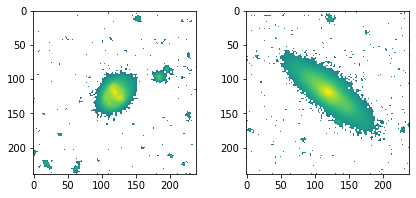

In [ ]:
#Low-z Data
fig, ax = plt.subplots(1,2,figsize=(7,3))

for i,img_num in enumerate([45849776612206843, 71112151477012948]):
  img_data = fits.getdata('/content/data_lowz/cutouts/' + str(img_num) + '.fits')

  #Now, let's crop the image to it's starting size
  img_data = crop_center(img_data, 239, 239)

  ax[i].imshow(img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))

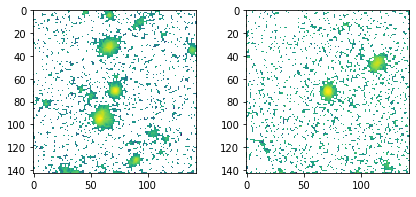

In [ ]:
#Mid-z Data
fig, ax = plt.subplots(1,2,figsize=(7,3))

for i,img_num in enumerate([38544642832100143, 40163802552993641]):
  img_data = fits.getdata('/content/data_midz/cutouts/' + str(img_num) + '.fits')

  #Now, let's crop the image to it's starting size
  img_data = crop_center(img_data, 143, 143)

  ax[i].imshow(img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))

## Running the AutoCropping Module

Now we make use of the `GaMPEN/ggt/autocrop.py` script to crop the input images and save them to a folder. To save the images, we create a new directory called `crop_cutouts/`

The `channels`,`n_pred`,`normalize`,`transform`,`parallel`,`errors`,`cov_errors`, `repeat_dims` all need to be set according to what was used while training the model that you are using for prediction.

The `image_dir` should point to a directory with all the `.fits` images you want to crop. The `out_dir` should point to a directory where you want to store the cropped images.

**For detailed description of all arguments of the autocropping module, please refer to the [Using GaMPEN page](https://gampen.readthedocs.io/en/latest/Using_GaMPEN.html#autocrop)**


Note: Saving cropped cutouts is not required for any part of GaMPEN's end to end ML process. This is mostly helpful if you want to use only the auto-cropping portion of a trained GaMPEN framework just to make cutouts.

### Low-z Model

In [ ]:
%mkdir /content/data_lowz/crop_cutouts/

In [ ]:
!python /content/GaMPEN/ggt/modules/autocrop.py\
  --model_type="vgg16_w_stn_oc_drp"\
  --model_path='/content/trained_models/g_0_025_real_data.pt'\
  --cutout_size=239\
  --channels=3\
  --n_pred=3\
  --image_dir="/content/data_lowz/cutouts/"\
  --out_dir="/content/data_lowz/crop_cutouts/"\
  --normalize\
  --transform\
  --repeat_dims\
  --parallel\
  --cov_errors

[2022-12-17 23:47:32,186] Using 1 GPUs <generator object discover_devices.<locals>.<genexpr> at 0x7f592c7d50b0>
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:02<00:00, 241MB/s]
[2022-12-17 23:47:39,839] Cropping 2 images...
100% 2/2 [00:00<00:00, 11.18it/s]


Now, let's inspect the original and cropped images together.

**The top row displays the original image and the bottom row displays the cropped image**

**As can be seen, the trained GaMPEN model does an excellent job at cropping the images to an optimal size**

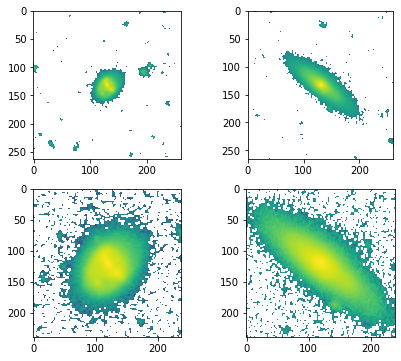

In [ ]:
#Low-z Data
fig, ax = plt.subplots(2,2,figsize=(7,6))
ax = ax.flatten()

for i,img_num in enumerate([45849776612206843, 71112151477012948]):

  img_data = fits.getdata('/content/data_lowz/cutouts/' + str(img_num) + '.fits')
  crop_img_data = fits.getdata('/content/data_lowz/crop_cutouts/' + str(img_num) + '.fits')
  
  #img_data = img_data[0,0,:,:]
  #Now, let's crop the image to it's starting size
  #img_data = crop_center(img_data, 239, 239)

  ax[i].imshow(img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))
  ax[i+2].imshow(crop_img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))

### Mid-z Model

In [ ]:
%mkdir /content/data_midz/crop_cutouts/

In [ ]:
!python /content/GaMPEN/ggt/modules/autocrop.py\
    --model_type="vgg16_w_stn_oc_drp"\
    --model_path="/content/trained_models/r_025_050_real_data.pt"\
    --cutout_size=143\
    --channels=3\
    --n_pred=3\
    --image_dir="/content/data_midz/cutouts/"\
    --normalize\
    --transform\
    --out_dir="/content/data_midz/crop_cutouts/"\
    --parallel\
    --cov_errors\
    --repeat_dims

[2022-12-17 23:50:12,734] Using 1 GPUs <generator object discover_devices.<locals>.<genexpr> at 0x7fd67bdbb0b0>
[2022-12-17 23:50:17,576] Cropping 2 images...
100% 2/2 [00:00<00:00, 63.64it/s]


Now, let's inspect the original and cropped images together.

**The top row displays the original image and the bottom row displays the cropped image**

**As can be seen, the trained GaMPEN model does an excellent job at cropping the images to an optimal size**

Note that in some images like the left one, there will still be secondary objects left in the frame, but GaMPEN models are automatically trained to focus on the object at the center and thus can still perform correct inference. 

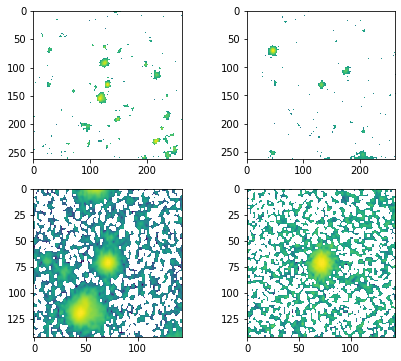

In [ ]:
#Low-z Data
fig, ax = plt.subplots(2,2,figsize=(7,6))
ax = ax.flatten()

for i,img_num in enumerate([38544642832100143,40163802552993641]):

  img_data = fits.getdata('/content/data_midz/cutouts/' + str(img_num) + '.fits')
  crop_img_data = fits.getdata('/content/data_midz/crop_cutouts/' + str(img_num) + '.fits')
  
  #img_data = img_data[0,0,:,:]
  #Now, let's crop the image to it's starting size
  #img_data = crop_center(img_data, 239, 239)

  ax[i].imshow(img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))
  ax[i+2].imshow(crop_img_data,norm=mpl.colors.LogNorm(vmin=max(img_data.min(),LOGMIN)))